# First Practical work

* Nutdaya Tipdubpai 
* NIA: 100523093
* José Miguel Santos Roldán:
* NIA:100523039
* Lea Fenz
* NIA: 100575194
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [25]:
!pip install nibabel

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [26]:

import numpy as np
from sys import getsizeof
import time
from os.path import join
import multiprocessing as mp

In [27]:
%matplotlib inline
import matplotlib_inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [28]:
import nibabel as nib

In [29]:
# import your_library here
from myfunction import Filter_three_Dimension,init_sharedarray,tonumpyarray

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [30]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [31]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [32]:
MYDRIVE="./"

In [33]:
MYDRIVE = os.getcwd()


We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [34]:
IMAGE=join(MYDRIVE,"someones_epi.nii","someones_epi.nii")

In [35]:
print("Image to load: {0}".format(IMAGE))

Image to load: c:\Users\Nutdaya\OneDrive\desktop\DS\third year\massive computing\First_Practical_100523093\someones_epi.nii\someones_epi.nii


Loads an image in a numpy variable, and show.

In [36]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [37]:
epi_img_data_final = epi_img_data.T

In [38]:
epi_img_data_final.shape

(33, 61, 53)

In [39]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

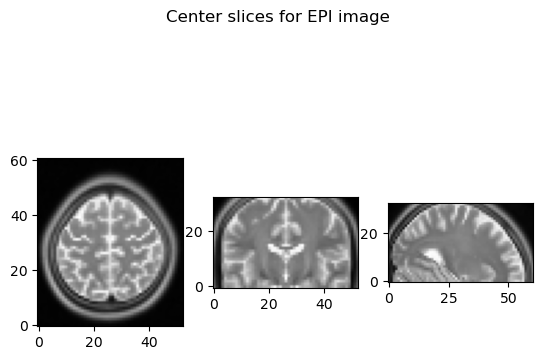

In [40]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [41]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [42]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [43]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [44]:
image_shape=epi_img_data_final.shape

Allocates the target image memory.

In [45]:
filtered_image_shm = mp.Array('f', int(np.prod(image_shape)))

### The next lines is only valid for the filter mask filter1, in order to check if the image was readed correct

In [46]:

filter_3d = Filter_three_Dimension(epi_img_data_final, filter3)


In [47]:

%%timeit -o -n 1 -r 1
with mp.Pool(
    processes=mp.cpu_count() - 1,
    initializer=init_sharedarray,
    initargs=(filtered_image_shm, image_shape)
) as pool:
    pool.map(filter_3d.edge_filter_row, range(image_shape[0]))

783 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 783 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [48]:
statistics = _


In [49]:

filtered_image = tonumpyarray(filtered_image_shm).reshape(image_shape)


*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

# Show results


Text(0.5, 0.98, 'Center slices for EPI image')

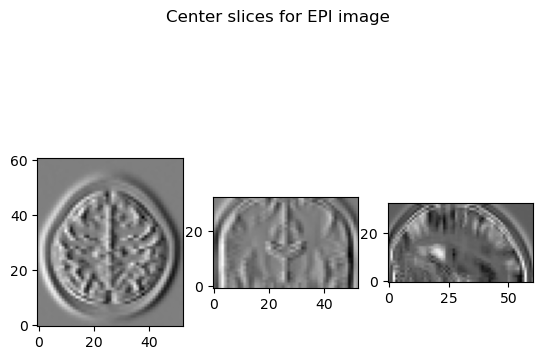

In [50]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

In [51]:
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.7828275000210851
Worst execution time: 0.7828275000210851
Mean execution time: 0.7828275000210851 (0.0 std dev)


# CONCLUSIONS